### Applied Data Science Capstone

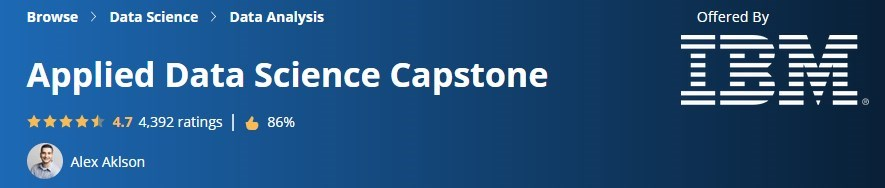

#### _This Notebook is related Coursera Capstone Project_

In [1]:
import pandas as pd
import numpy as np

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


# Week 3
## Segmenting and Clustering Neighborhoods in Toronto
### Applied Data Science Capstone Week 3 

In [4]:
!pip -q install folium

In [5]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for webscraping import Beautiful Soup 
from bs4 import BeautifulSoup

import xml


import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Scraping the data from the Wikipedia page of the postal codes of Canada

In [6]:
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [7]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [8]:
# create three lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []

In [9]:
# append the data into the respective lists
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) == 3):
        postalCodeList.append(cells[0].text.rstrip('\n'))
        boroughList.append(cells[1].text.rstrip('\n'))
        neighborhoodList.append(cells[2].text.rstrip('\n')) # avoid new lines in neighborhood cell

In [10]:
# create a new DataFrame from the three lists
toronto_df = pd.DataFrame({"PostalCode": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})

toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


##  Drop cells with a borough that is "Not assigned"

In [11]:
# drop cells with a borough that is Not assigned
toronto_df_dropna = toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)
toronto_df_dropna.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## Group neighborhoods in the same borough

In [12]:
# group neighborhoods in the same borough
toronto_df_grouped = toronto_df_dropna.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [13]:
# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in toronto_df_grouped.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
        
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## For Neighborhood="Not assigned", make the value the same as Borough

In [14]:
# create a new test dataframe
column_names = ["PostalCode", "Borough", "Neighborhood"]
test_df = pd.DataFrame(columns=column_names)

test_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in test_list:
    test_df = test_df.append(toronto_df_grouped[toronto_df_grouped["PostalCode"]==postcode], ignore_index=True)
    
test_df.head()

,PostalCode,Borough,Neighborhood
0,M5G,Downtown Toronto,Central Bay Street
1,M2H,North York,Hillcrest Village
2,M4B,East York,"Parkview Hill, Woodbine Gardens"
3,M1J,Scarborough,Scarborough Village
4,M4G,East York,Leaside


## Check whether it is the same as required by the question

In [15]:
# print the number of rows of the cleaned dataframe
toronto_df_grouped.shape

(103, 3)

## Load the coordinates from the csv file on Coursera

In [18]:
coordinates = pd.read_csv("http://cocl.us/Geospatial_data")
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [19]:
coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


##  Merge two tables to get the coordinates

In [20]:
toronto_df_new = toronto_df_grouped.merge(coordinates, on="PostalCode", how="left")
toronto_df_new.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Finally, check to make sure the coordinates are added as required by the question

In [21]:
# create a new test dataframe
column_names = ["PostalCode", "Borough", "Neighborhood", "Latitude", "Longitude"]
test_df = pd.DataFrame(columns=column_names)

test_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in test_list:
    test_df = test_df.append(toronto_df_new[toronto_df_new["PostalCode"]==postcode], ignore_index=True)
    
test_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
1,M2H,North York,Hillcrest Village,43.803762,-79.363452
2,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
4,M4G,East York,Leaside,43.709060,-79.363452
5,M4M,East Toronto,Studio District,43.659526,-79.340923
6,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849
7,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420


## Geopy library to get the latitude and longitude values of Toronto

In [22]:
address = 'Toronto'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


## Create a map of Toronto with neighborhoods superimposed on top

In [23]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto 

## Filter only boroughs that contain the word Toronto

In [24]:
# filter borough names that contain the word Toronto
borough_names = list(toronto_df_new.Borough.unique())

borough_with_toronto = []

for x in borough_names:
    if "toronto" in x.lower():
        borough_with_toronto.append(x)
        
borough_with_toronto

['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']

In [25]:
# create a new DataFrame with only boroughs that contain the word Toronto
toronto_df_new = toronto_df_new[toronto_df_new['Borough'].isin(borough_with_toronto)].reset_index(drop=True)
print(toronto_df_new.shape)
toronto_df_new.head()

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [26]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto 

In [29]:
# define Foursquare Credentials and Version
CLIENT_ID = 'HSDLLIUQF1BU3MTCCDHAL5S5TXI4ELXIVNYKCHROHBIADRTJ' # your Foursquare ID
CLIENT_SECRET = '5YXUTR53CJWL4W4NKE0OCY5B42TDWHQJKFZYYSPCJEAABVYC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HSDLLIUQF1BU3MTCCDHAL5S5TXI4ELXIVNYKCHROHBIADRTJ
CLIENT_SECRET:5YXUTR53CJWL4W4NKE0OCY5B42TDWHQJKFZYYSPCJEAABVYC


## Getting the top 100 venues that are within a radius of 500 meters.

In [30]:
radius = 500
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['PostalCode'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [31]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1638, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,East Toronto,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,East Toronto,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop


### Venues were returned for each PostalCode

In [32]:
venues_df.groupby(["PostalCode", "Borough", "Neighborhood"]).count()

,,,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,Borough,Neighborhood,,,,,,
M4E,East Toronto,The Beaches,6,6,6,6,6,6
M4K,East Toronto,"The Danforth West, Riverdale",42,42,42,42,42,42
M4L,East Toronto,"India Bazaar, The Beaches West",21,21,21,21,21,21
M4M,East Toronto,Studio District,40,40,40,40,40,40
M4N,Central Toronto,Lawrence Park,4,4,4,4,4,4
M4P,Central Toronto,Davisville North,9,9,9,9,9,9
M4R,Central Toronto,"North Toronto West, Lawrence Park",20,20,20,20,20,20
M4S,Central Toronto,Davisville,34,34,34,34,34,34
M4T,Central Toronto,"Moore Park, Summerhill East",2,2,2,2,2,2


### Unique categories from all returned values

In [33]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 232 uniques categories.


In [34]:
venues_df['VenueCategory'].unique()[:50]


array(['Trail', 'Health Food Store', 'Pub', 'Neighborhood', 'Coffee Shop',
       'Asian Restaurant', 'Cosmetics Shop', 'Greek Restaurant',
       'Italian Restaurant', 'Brewery', 'Ice Cream Shop', 'Yoga Studio',
       'Juice Bar', 'Fruit & Vegetable Store', 'Restaurant', 'Bookstore',
       'Pizza Place', 'Café', 'Dessert Shop', 'Furniture / Home Store',
       'Bubble Tea Shop', 'Spa', 'Grocery Store', 'Bakery',
       'Caribbean Restaurant', 'Indian Restaurant', 'American Restaurant',
       'Lounge', 'Frozen Yogurt Shop', 'Liquor Store', 'Sushi Restaurant',
       'Gym', 'Fast Food Restaurant', 'Fish & Chips Shop', 'Park',
       'Burrito Place', 'Pet Store', 'Steakhouse', 'Movie Theater',
       'Sandwich Place', 'Board Shop', 'Light Rail Station',
       'Food & Drink Shop', 'Fish Market', 'Cheese Shop', 'Gay Bar',
       'Seafood Restaurant', 'Middle Eastern Restaurant',
       'Stationery Store', 'Comfort Food Restaurant'], dtype=object)

### Analyze Each Area

In [35]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
toronto_onehot['PostalCode'] = venues_df['PostalCode'] 
toronto_onehot['Borough'] = venues_df['Borough'] 
toronto_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1638, 235)


,PostalCode,Borough,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [36]:
toronto_grouped = toronto_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped

(39, 235)


,PostalCode,Borough,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

### The top 10 venues for each PostalCode

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_grouped['Neighborhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    row_categories = toronto_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(39, 13)


,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,Health Food Store,Coffee Shop,Asian Restaurant,Neighborhood,Trail,Pub,Discount Store,Dessert Shop,Dim Sum Restaurant,Diner
1,M4K,East Toronto,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Bubble Tea Shop,Bakery,Pub,Pizza Place
2,M4L,East Toronto,"India Bazaar, The Beaches West",Park,Food & Drink Shop,Sandwich Place,Liquor Store,Burrito Place,Board Shop,Italian Restaurant,Restaurant,Ice Cream Shop,Steakhouse
3,M4M,East Toronto,Studio District,Café,Coffee Shop,Gastropub,Brewery,Bakery,American Restaurant,Comfort Food Restaurant,Sandwich Place,Cheese Shop,Clothing Store
4,M4N,Central Toronto,Lawrence Park,Park,Swim School,Dim Sum Restaurant,Bus Line,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
5,M4P,Central Toronto,Davisville North,Hotel,Gym,Food & Drink Shop,Sandwich Place,Gym / Fitness Center,Department Store,Pizza Place,Park,Breakfast Spot,Donut Shop
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",Coffee Shop,Clothing Store,Yoga Studio,Café,Diner,Salon / Barbershop,Spa,Sporting Goods Shop,Italian Restaurant,Fast Food Restaurant
7,M4S,Central Toronto,Davisville,Sandwich Place,Dessert Shop,Coffee Shop,Gym,Café,Pizza Place,Italian Restaurant,Sushi Restaurant,Greek Restaurant,Brewery
8,M4T,Central Toronto,"Moore Park, Summerhill East",Trail,Restaurant,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",Coffee Shop,Pub,Supermarket,Light Rail Station,Vietnamese Restaurant,Sushi Restaurant,Liquor Store,Bagel Shop,American Restaurant,Pizza Place


### Cluster Areas
#### Using the K-means algorithm to cluster into 5 

In [38]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop(["PostalCode", "Borough", "Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 4, 4, 2, 4, 4, 4, 1, 4], dtype=int32)

In [39]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_df_new.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.drop(["Borough", "Neighborhoods"], 1).set_index("PostalCode"), on="PostalCode")

print(toronto_merged.shape)
toronto_merged.head() # check the last columns!

(39, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Coffee Shop,Asian Restaurant,Neighborhood,Trail,Pub,Discount Store,Dessert Shop,Dim Sum Restaurant,Diner
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,4,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Bubble Tea Shop,Bakery,Pub,Pizza Place
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,4,Park,Food & Drink Shop,Sandwich Place,Liquor Store,Burrito Place,Board Shop,Italian Restaurant,Restaurant,Ice Cream Shop,Steakhouse
3,M4M,East Toronto,Studio District,43.659526,-79.340923,4,Café,Coffee Shop,Gastropub,Brewery,Bakery,American Restaurant,Comfort Food Restaurant,Sandwich Place,Cheese Shop,Clothing Store
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Park,Swim School,Dim Sum Restaurant,Bus Line,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [40]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_df_new.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.drop(["Borough", "Neighborhoods"], 1).set_index("PostalCode"), on="PostalCode")

print(toronto_merged.shape)
toronto_merged.head() # check the last columns!

(39, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Coffee Shop,Asian Restaurant,Neighborhood,Trail,Pub,Discount Store,Dessert Shop,Dim Sum Restaurant,Diner
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,4,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Bubble Tea Shop,Bakery,Pub,Pizza Place
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,4,Park,Food & Drink Shop,Sandwich Place,Liquor Store,Burrito Place,Board Shop,Italian Restaurant,Restaurant,Ice Cream Shop,Steakhouse
3,M4M,East Toronto,Studio District,43.659526,-79.340923,4,Café,Coffee Shop,Gastropub,Brewery,Bakery,American Restaurant,Comfort Food Restaurant,Sandwich Place,Cheese Shop,Clothing Store
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Park,Swim School,Dim Sum Restaurant,Bus Line,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


###  Visualizing  the resulting clusters

In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Borough'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###  Examine Clusters

## Cluster 1

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Health Food Store,Coffee Shop,Asian Restaurant,Neighborhood,Trail,Pub,Discount Store,Dessert Shop,Dim Sum Restaurant,Diner
10,Downtown Toronto,0,Park,Playground,Trail,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
23,Central Toronto,0,Park,Jewelry Store,Trail,Sushi Restaurant,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


## Cluster 2


In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,1,Trail,Restaurant,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


## Cluster 3


In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,2,Park,Swim School,Dim Sum Restaurant,Bus Line,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


## Cluster 4

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,3,Garden,Home Service,Music Venue,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


## Cluster 5

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,East Toronto,4,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Bubble Tea Shop,Bakery,Pub,Pizza Place
2,East Toronto,4,Park,Food & Drink Shop,Sandwich Place,Liquor Store,Burrito Place,Board Shop,Italian Restaurant,Restaurant,Ice Cream Shop,Steakhouse
3,East Toronto,4,Café,Coffee Shop,Gastropub,Brewery,Bakery,American Restaurant,Comfort Food Restaurant,Sandwich Place,Cheese Shop,Clothing Store
5,Central Toronto,4,Hotel,Gym,Food & Drink Shop,Sandwich Place,Gym / Fitness Center,Department Store,Pizza Place,Park,Breakfast Spot,Donut Shop
6,Central Toronto,4,Coffee Shop,Clothing Store,Yoga Studio,Café,Diner,Salon / Barbershop,Spa,Sporting Goods Shop,Italian Restaurant,Fast Food Restaurant
7,Central Toronto,4,Sandwich Place,Dessert Shop,Coffee Shop,Gym,Café,Pizza Place,Italian Restaurant,Sushi Restaurant,Greek Restaurant,Brewery
9,Central Toronto,4,Coffee Shop,Pub,Supermarket,Light Rail Station,Vietnamese Restaurant,Sushi Restaurant,Liquor Store,Bagel Shop,American Restaurant,Pizza Place
11,Downtown Toronto,4,Coffee Shop,Café,Italian Restaurant,Restaurant,Pub,Pizza Place,Park,Bakery,Playground,Chinese Restaurant
12,Downtown Toronto,4,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Pub,Men's Store,Mediterranean Restaurant,Hotel,Dance Studio
13,Downtown Toronto,4,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Dessert Shop,Shoe Store,Restaurant


**Conclusions**

**Cluster 1** which are mostly business areas with cafe, restaurants, supermarkets etc.
**Cluster 2** is just a garden 
**Cluster 3** are playground and park, 
**Cluster 4** park and swim school
**Cluster 5** park and trail.